In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, PercentFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import seaborn as sns


In [2]:
train = pd.read_csv('../input/tabular-playground-series-mar-2022/train.csv')
test = pd.read_csv('../input/tabular-playground-series-mar-2022/test.csv', index_col='row_id')

In [3]:
def add_datetime_features(df):
    df['month']   = df['time'].dt.month
    df['day']     = df['time'].dt.day
    df['weekday'] = df['time'].dt.weekday
    df['weekend'] = (df['time'].dt.weekday >= 5)
    df['hour']    = df['time'].dt.hour
    df['minute']  = df['time'].dt.minute
    df['afternoon'] = df['hour'] >= 12

In [4]:
train.time = pd.to_datetime(train.time)
train['daytime_id'] = ( ( train.time.dt.hour*60 + train.time.dt.minute ) /20 ).astype(int)
train = train.set_index('row_id', drop=True)
train['roadway'] = train.x.astype('str') +'_'+ train.y.astype('str') +'_'+ train.direction.astype('str')


test.time = pd.to_datetime(test.time)
test['roadway'] = test.x.astype('str') +'_'+ test.y.astype('str') +'_'+ test.direction.astype('str') 

In [5]:
add_datetime_features(train)
add_datetime_features(test)

In [6]:
train.head()

,time,x,y,direction,congestion,daytime_id,roadway,month,day,weekday,weekend,hour,minute,afternoon
row_id,,,,,,,,,,,,,,
0,1991-04-01,0,0,EB,70,0,0_0_EB,4,1,0,False,0,0,False
1,1991-04-01,0,0,NB,49,0,0_0_NB,4,1,0,False,0,0,False
2,1991-04-01,0,0,SB,24,0,0_0_SB,4,1,0,False,0,0,False
3,1991-04-01,0,1,EB,18,0,0_1_EB,4,1,0,False,0,0,False
4,1991-04-01,0,1,NB,60,0,0_1_NB,4,1,0,False,0,0,False


# Mutual Information 

In [7]:
le = LabelEncoder()
X_train = train.copy()
y_train = X_train['congestion']
X_train = X_train.drop(['time','congestion'],axis=1)
X_train['roadway'] = le.fit_transform(X_train['roadway'])
X_train['direction'] = le.fit_transform(X_train['direction'])


In [8]:
from sklearn.feature_selection import mutual_info_regression

mi_scores = mutual_info_regression(X_train, y_train)
mi_scores = pd.Series(mi_scores, name="MI_score", index=X_train.columns)
mi_scores = mi_scores.sort_values(ascending=False)
df_mi_scores = pd.DataFrame(mi_scores).reset_index().rename(columns={'index':'feature'})
df_mi_scores

,feature,MI_score
0,roadway,0.707922
1,direction,0.208112
2,y,0.064939
3,x,0.054100
4,daytime_id,0.043006
5,hour,0.042680
6,afternoon,0.017094
7,weekday,0.005277
8,weekend,0.003374
9,day,0.001769


# Lasso

In [9]:
from sklearn.linear_model import Lasso

cols = X_train.columns
lasso = Lasso()

coef = lasso.fit(X_train,y_train).coef_
np.array(cols)[coef !=0]

array(['y', 'direction', 'daytime_id', 'roadway', 'day', 'weekday',
       'minute'], dtype=object)

# Permutaion Importance

In [10]:
import eli5
from catboost import CatBoostRegressor
from eli5.sklearn import PermutationImportance

model = CatBoostRegressor(logging_level='Silent', random_state=42, eval_metric='MAE', loss_function='MAE').fit(X_train,y_train)

perm = PermutationImportance(model, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist(), top=None)

Weight,Feature
0.5632 ± 0.0007,roadway
0.4149 ± 0.0009,direction
0.2414 ± 0.0013,y
0.0829 ± 0.0002,daytime_id
0.0287 ± 0.0001,hour
0.0146 ± 0.0002,weekday
0.0058 ± 0.0001,weekend
0.0027 ± 0.0000,month
0.0021 ± 0.0000,x
0.0020 ± 0.0000,afternoon


# SHAP

(848835, 12) (848835, 12)


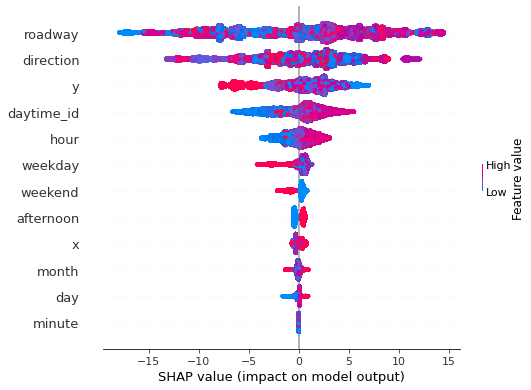

None

In [11]:
import shap

explainer = shap.TreeExplainer(model)    
shap_values = explainer.shap_values(X_train)
print(X_train.shape, shap_values.shape)
plt = shap.summary_plot(shap_values, X_train, max_display=X_train.shape[1])
display(plt)

The roadway seems to be the most informative feature

In [12]:
#182 days in the training data 
train['time'][848834] - train['time'][0]

Timedelta('182 days 11:40:00')

In [13]:
train['roadway'].nunique()

65

In [14]:
train['daytime_id'].nunique()

72

Text(0.5, 1.0, 'Congestion Histogram')

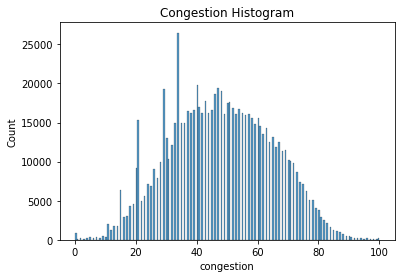

In [15]:
# Histogram of all congestions
plot = sns.histplot(train['congestion'])
plot.set_title('Congestion Histogram')

In [16]:
x = train['congestion'].value_counts()
x[:10]

34    26498
40    19797
47    19418
29    19236
48    19013
46    18717
43    17791
51    17681
50    17480
41    16935
Name: congestion, dtype: int64

The data looks normal. The values 34, 29, and 20 seem to appear more often then other congestion values around them.

# Roadway EDA

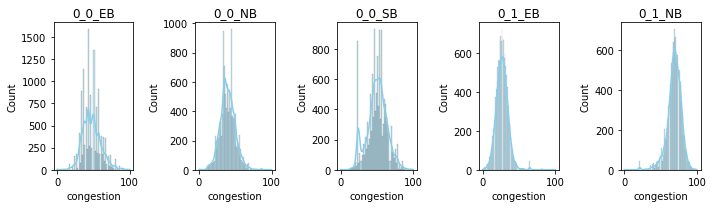

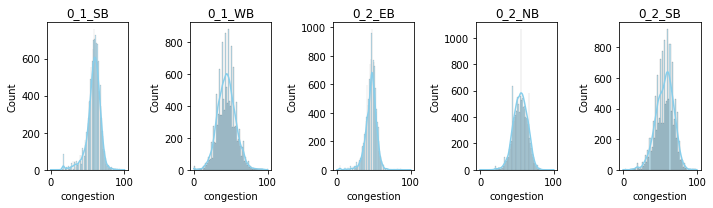

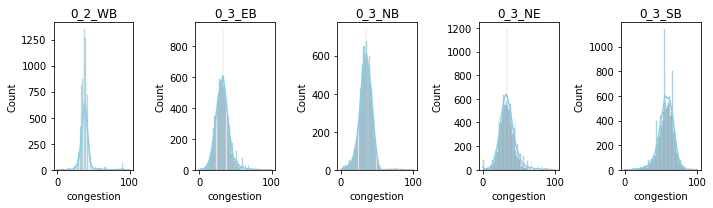

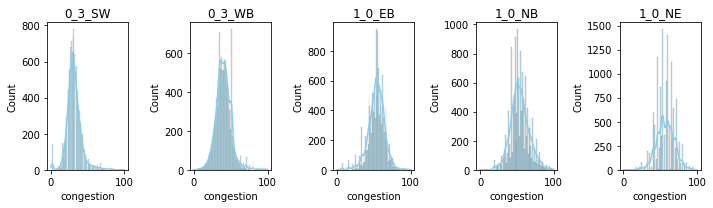

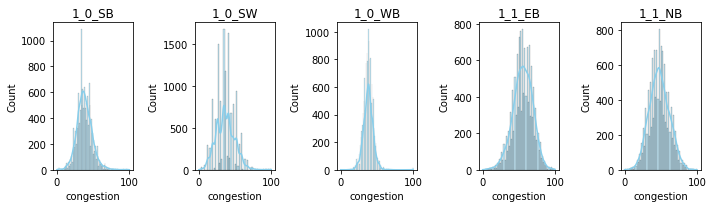

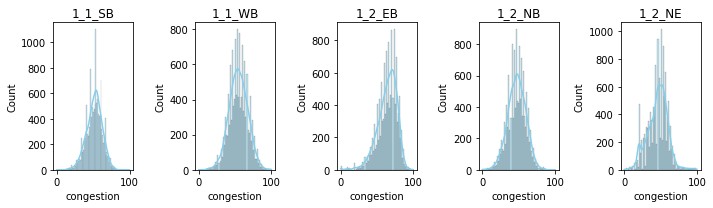

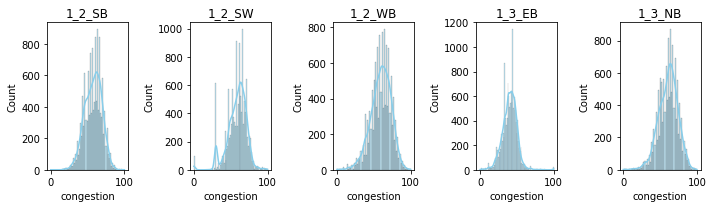

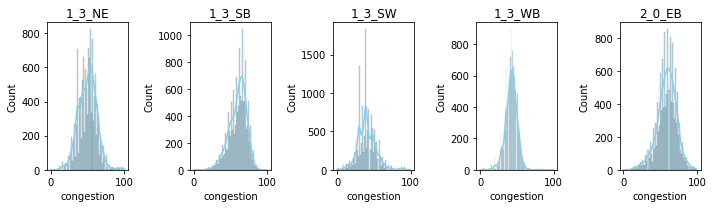

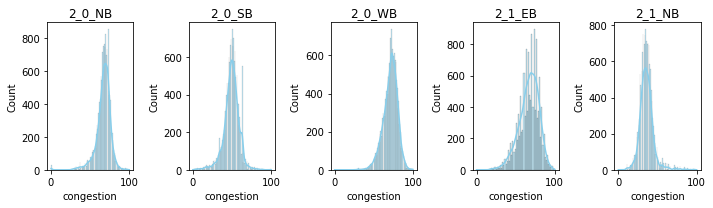

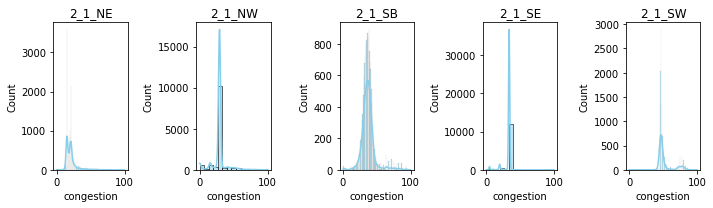

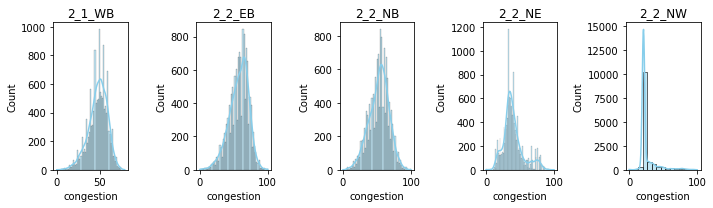

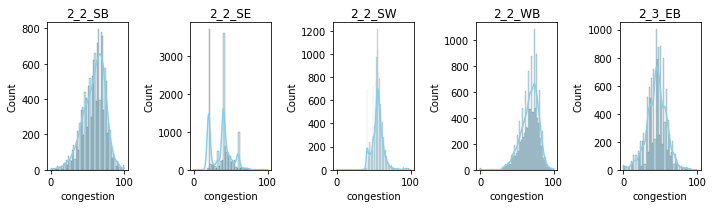

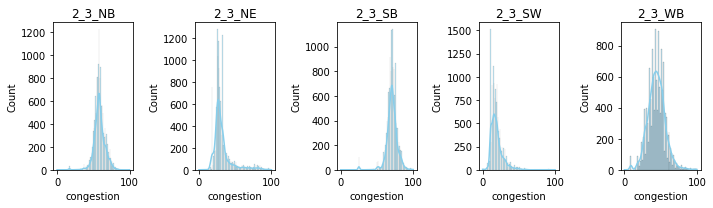

In [17]:
import matplotlib.pyplot as plt

rw = train.roadway.unique()

i=0
while i < len(rw):
    fig, axs = plt.subplots(1,5,figsize=(10, 3))
    sns.histplot(data=train,x=train.congestion[train.roadway==rw[i]], kde=True, color="skyblue",ax=axs[0])
    axs[0].set_title(f'{rw[i]}')
    sns.histplot(data=train,x=train.congestion[train.roadway==rw[i+1]], kde=True, color="skyblue",ax=axs[1])
    axs[1].set_title(f'{rw[i+1]}')
    sns.histplot(data=train,x=train.congestion[train.roadway==rw[i+2]], kde=True, color="skyblue",ax=axs[2])
    axs[2].set_title(f'{rw[i+2]}')
    sns.histplot(data=train,x=train.congestion[train.roadway==rw[i+3]], kde=True, color="skyblue",ax=axs[3])
    axs[3].set_title(f'{rw[i+3]}')
    sns.histplot(data=train,x=train.congestion[train.roadway==rw[i+4]], kde=True, color="skyblue",ax=axs[4])
    axs[4].set_title(f'{rw[i+4]}')

    i+=5
    plt.tight_layout()
    plt.show()

While most of the histograms show that the roadways show a normal distribution of congestions there are a few noteable roadways that are bimodal: 0_0_SB,1_2_NE,1_2_SW,2_2_NE,and 2_2_SE , so all these roadways will be investigated further.

In [18]:
_00sb = train[train.roadway=="0_0_SB"]
_12ne = train[train.roadway=="1_2_NE"]
_12sw = train[train.roadway=="1_2_SW"]
_22ne = train[train.roadway=="2_2_NE"]
_22se = train[train.roadway=="2_2_SE"]


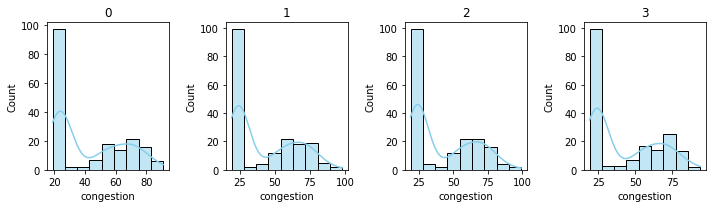

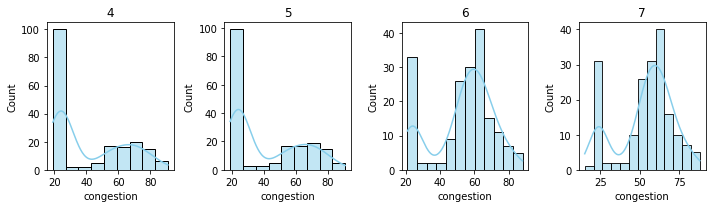

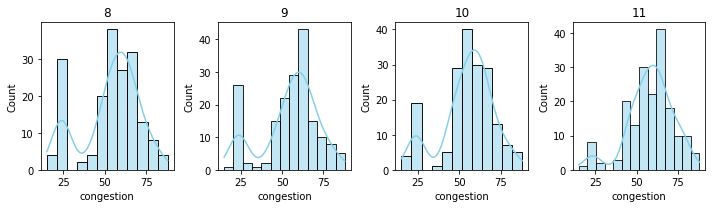

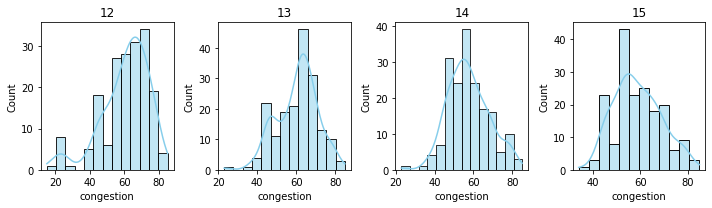

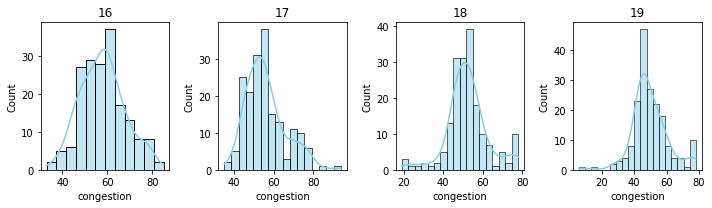

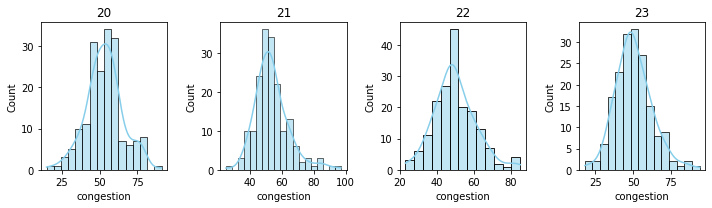

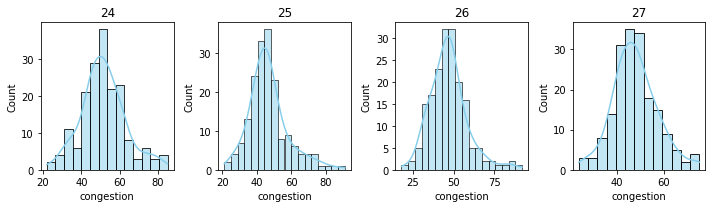

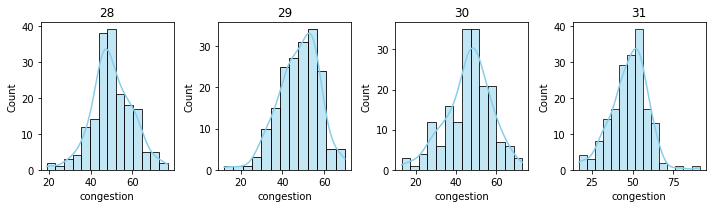

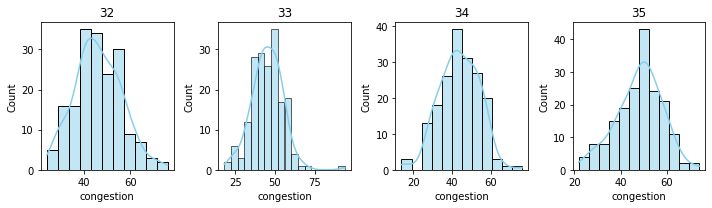

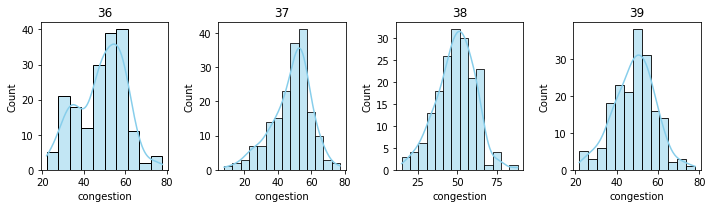

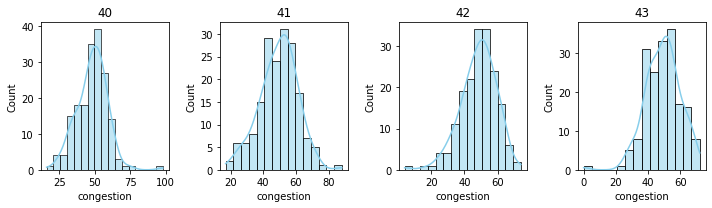

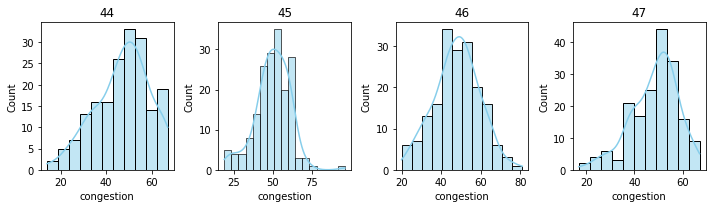

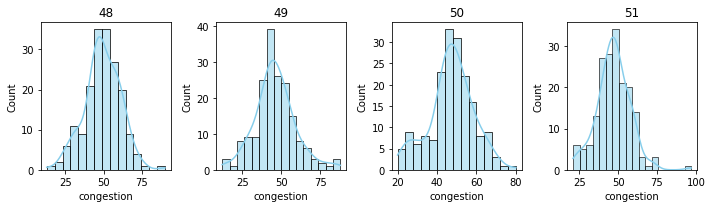

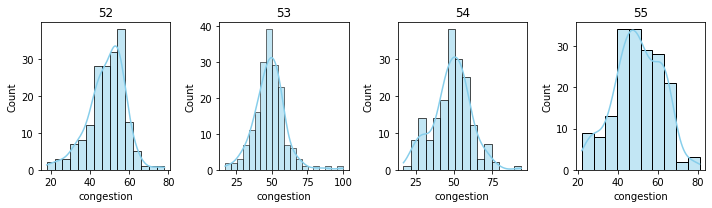

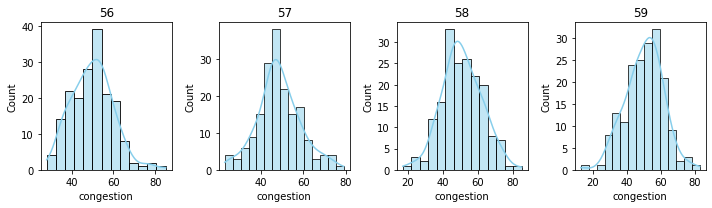

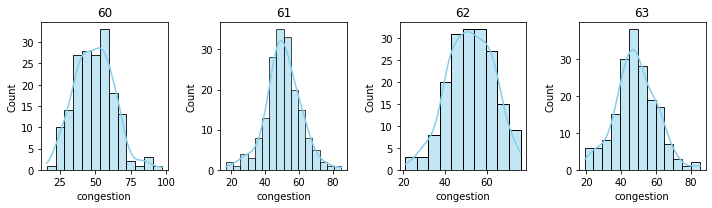

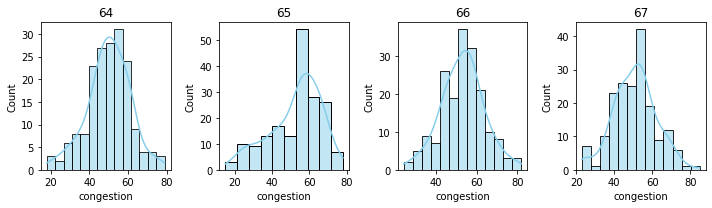

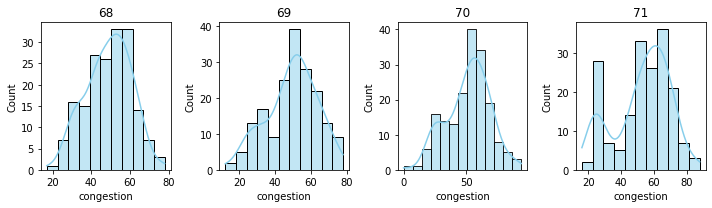

In [19]:
dt = _00sb.daytime_id.unique()

i=0
while i < len(dt):
    fig, axs = plt.subplots(1,4,figsize=(10, 3))
    sns.histplot(data=train,x=_00sb.congestion[_00sb.daytime_id==dt[i]], kde=True, color="skyblue",ax=axs[0])
    axs[0].set_title(f'{dt[i]}')
    sns.histplot(data=train,x=_00sb.congestion[_00sb.daytime_id==dt[i+1]], kde=True, color="skyblue",ax=axs[1])
    axs[1].set_title(f'{dt[i+1]}')
    sns.histplot(data=train,x=_00sb.congestion[_00sb.daytime_id==dt[i+2]], kde=True, color="skyblue",ax=axs[2])
    axs[2].set_title(f'{dt[i+2]}')
    sns.histplot(data=train,x=_00sb.congestion[_00sb.daytime_id==dt[i+3]], kde=True, color="skyblue",ax=axs[3])
    axs[3].set_title(f'{dt[i+3]}')
   
    i+=4
    plt.tight_layout()
    plt.show()

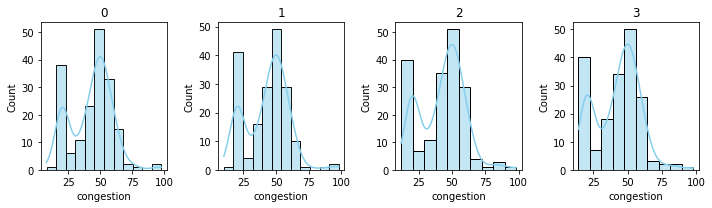

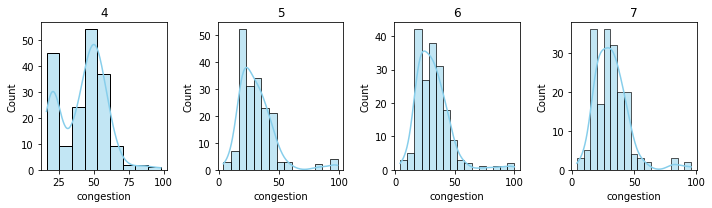

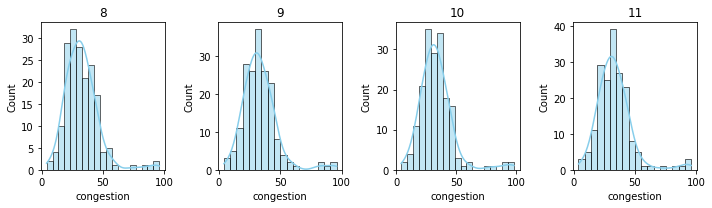

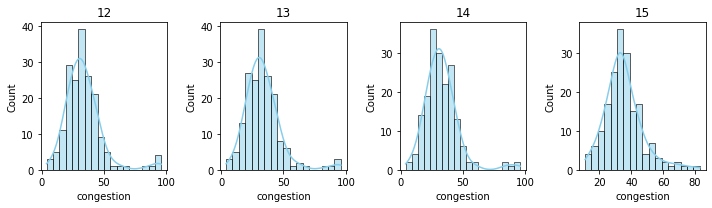

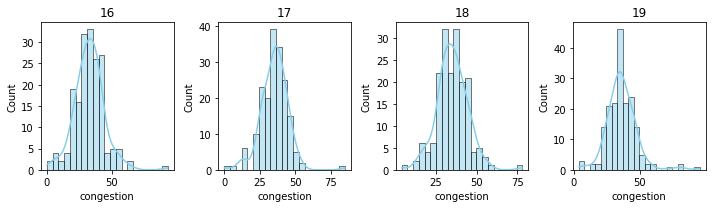

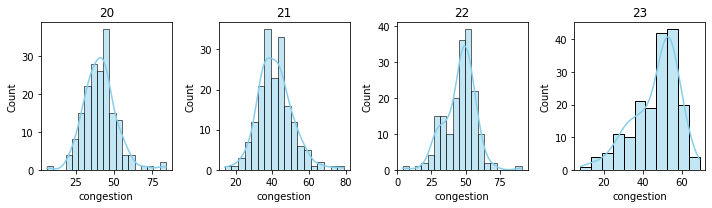

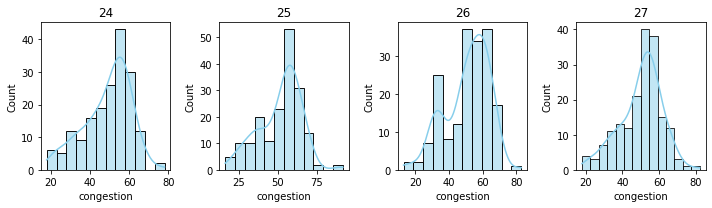

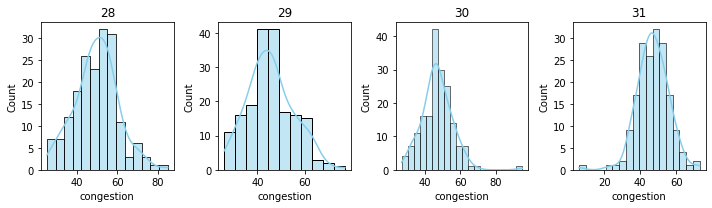

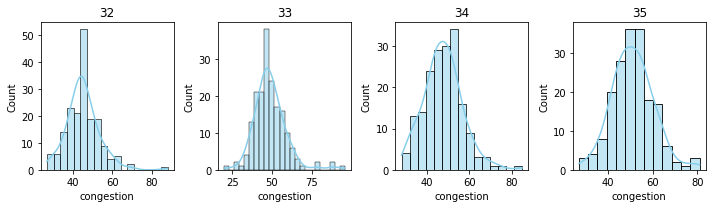

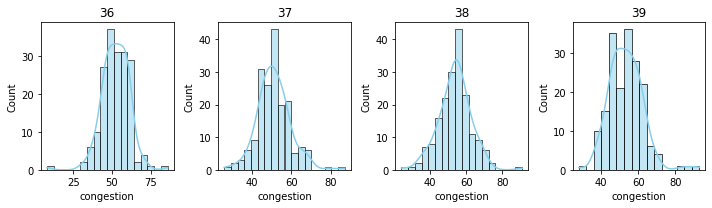

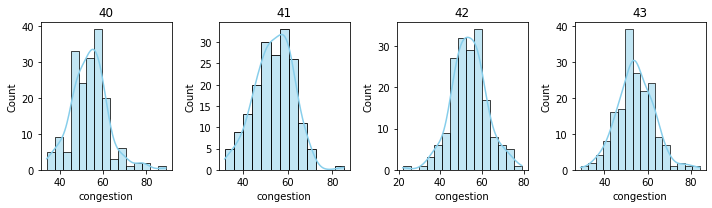

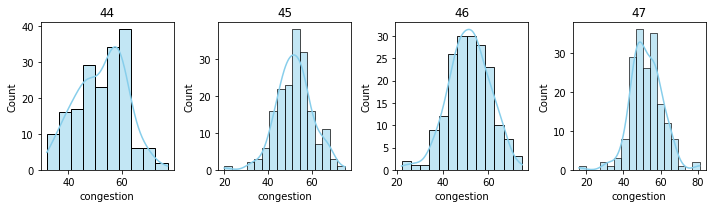

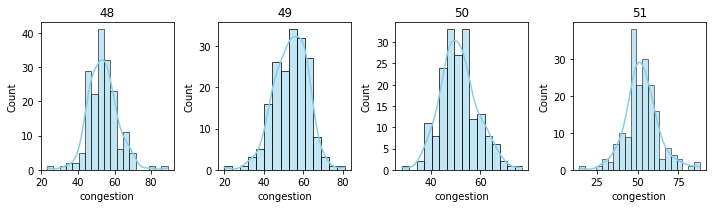

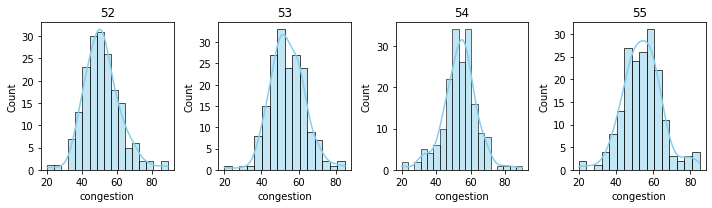

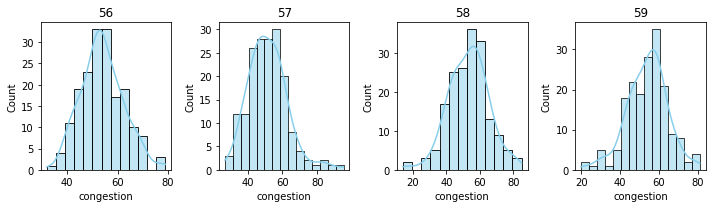

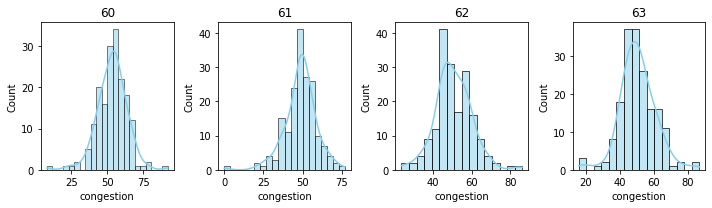

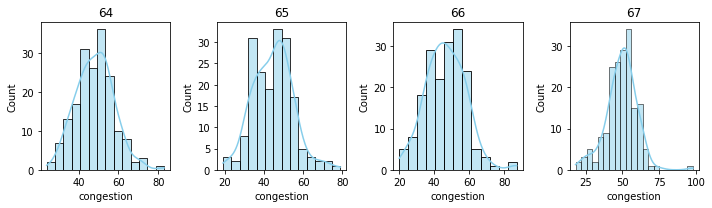

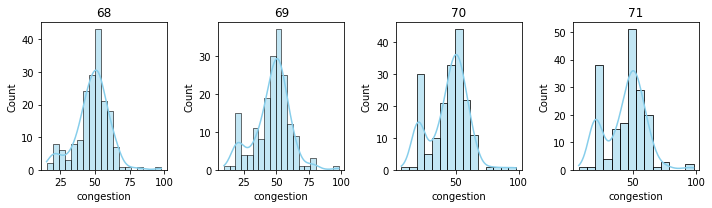

In [20]:
dt = _12ne.daytime_id.unique()

i=0
while i < len(dt):
    fig, axs = plt.subplots(1,4,figsize=(10, 3))
    sns.histplot(data=train,x=_12ne.congestion[_12ne.daytime_id==dt[i]], kde=True, color="skyblue",ax=axs[0])
    axs[0].set_title(f'{dt[i]}')
    sns.histplot(data=train,x=_12ne.congestion[_12ne.daytime_id==dt[i+1]], kde=True, color="skyblue",ax=axs[1])
    axs[1].set_title(f'{dt[i+1]}')
    sns.histplot(data=train,x=_12ne.congestion[_12ne.daytime_id==dt[i+2]], kde=True, color="skyblue",ax=axs[2])
    axs[2].set_title(f'{dt[i+2]}')
    sns.histplot(data=train,x=_12ne.congestion[_12ne.daytime_id==dt[i+3]], kde=True, color="skyblue",ax=axs[3])
    axs[3].set_title(f'{dt[i+3]}')
   
    i+=4
    plt.tight_layout()
    plt.show()

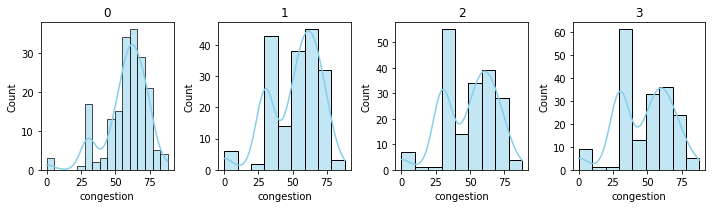

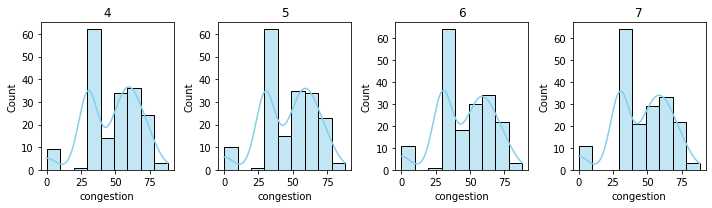

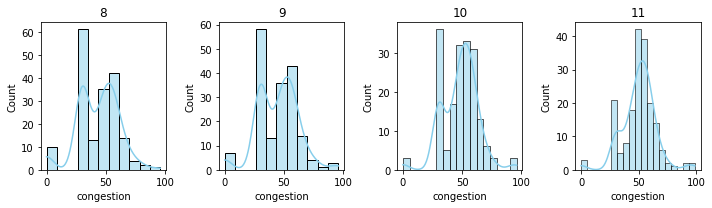

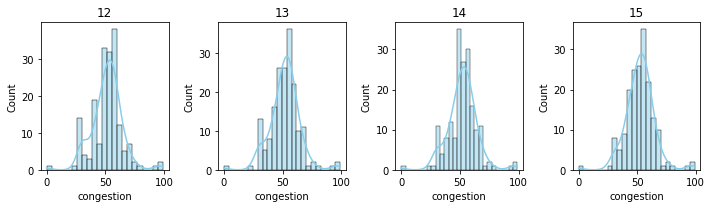

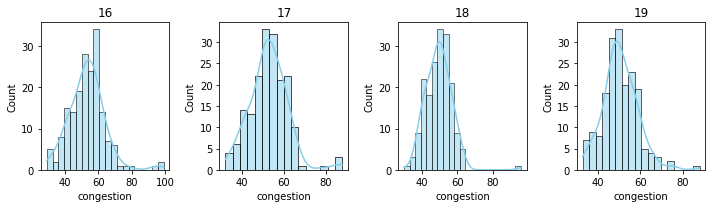

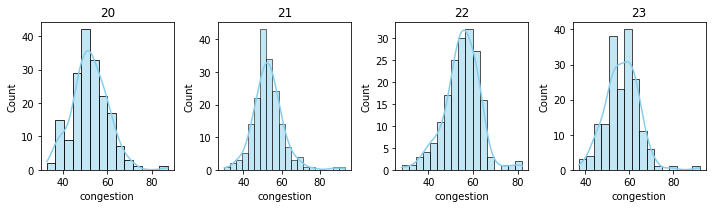

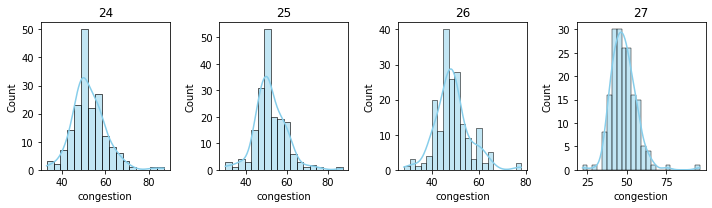

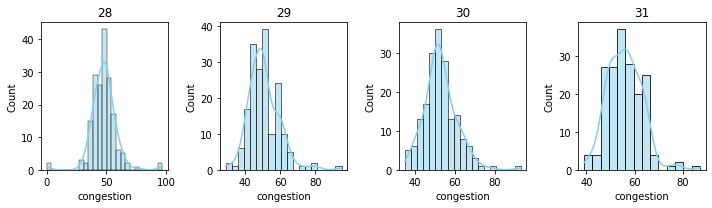

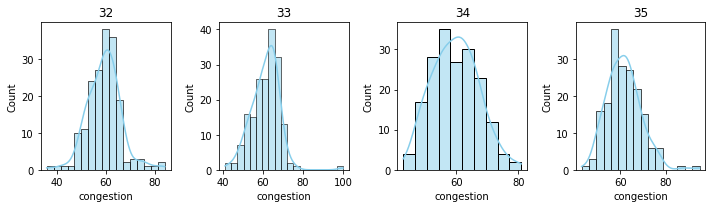

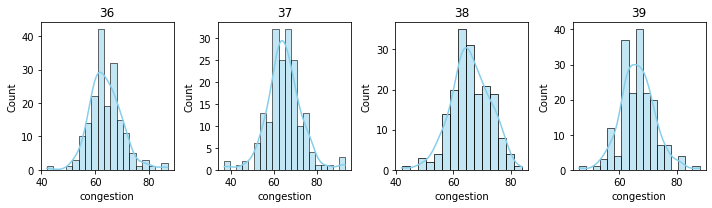

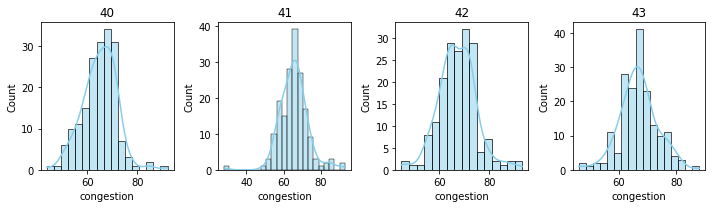

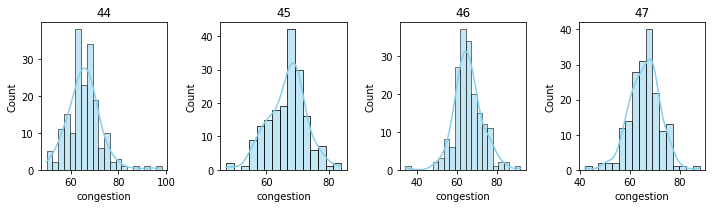

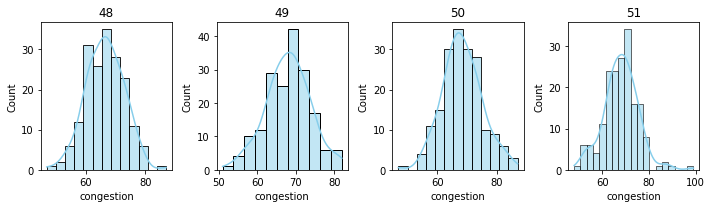

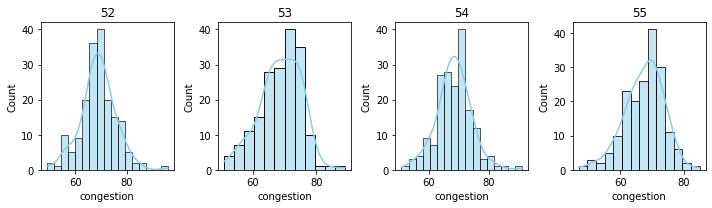

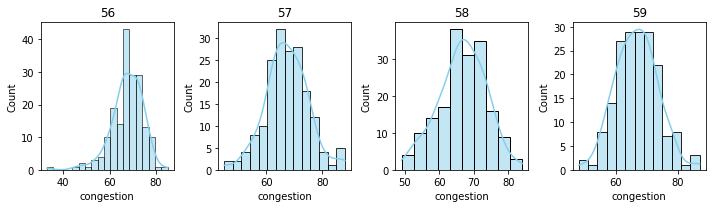

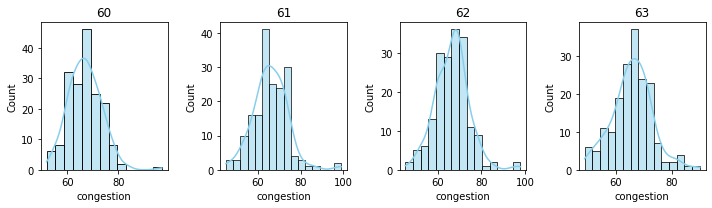

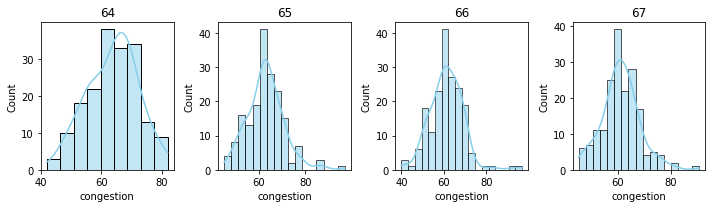

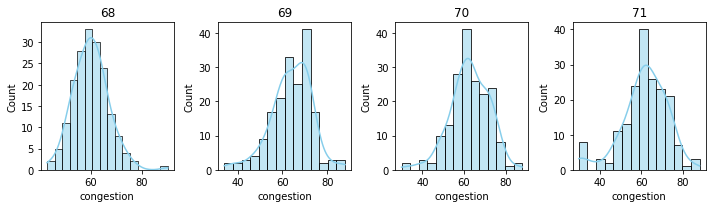

In [21]:
dt = _12sw.daytime_id.unique()

i=0
while i < len(dt):
    fig, axs = plt.subplots(1,4,figsize=(10, 3))
    sns.histplot(data=train,x=_12sw.congestion[_12sw.daytime_id==dt[i]], kde=True, color="skyblue",ax=axs[0])
    axs[0].set_title(f'{dt[i]}')
    sns.histplot(data=train,x=_12sw.congestion[_12sw.daytime_id==dt[i+1]], kde=True, color="skyblue",ax=axs[1])
    axs[1].set_title(f'{dt[i+1]}')
    sns.histplot(data=train,x=_12sw.congestion[_12sw.daytime_id==dt[i+2]], kde=True, color="skyblue",ax=axs[2])
    axs[2].set_title(f'{dt[i+2]}')
    sns.histplot(data=train,x=_12sw.congestion[_12sw.daytime_id==dt[i+3]], kde=True, color="skyblue",ax=axs[3])
    axs[3].set_title(f'{dt[i+3]}')
   
    i+=4
    plt.tight_layout()
    plt.show()

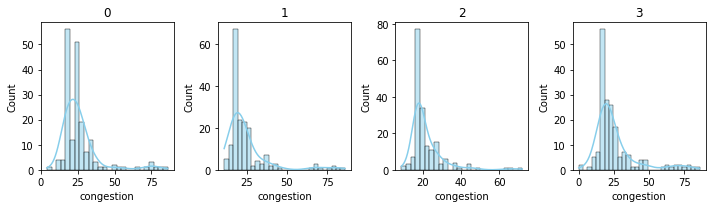

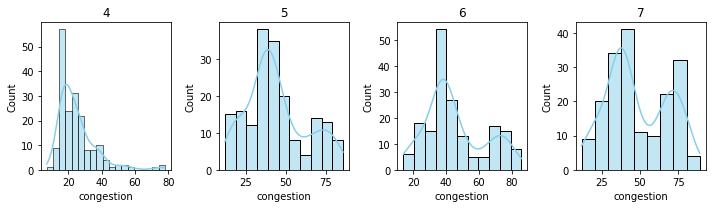

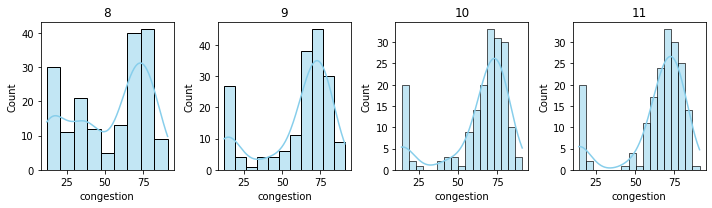

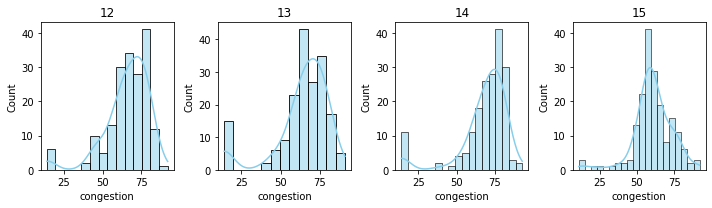

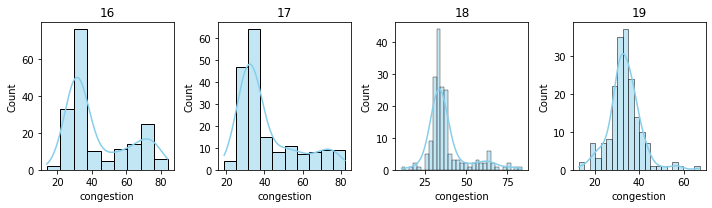

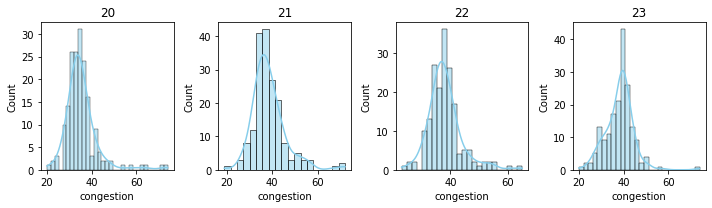

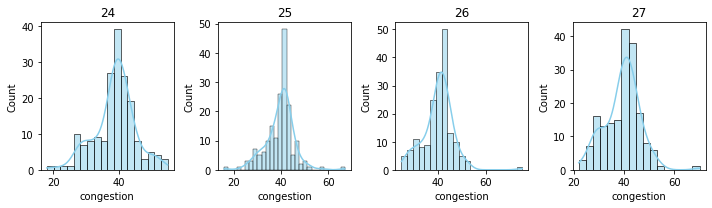

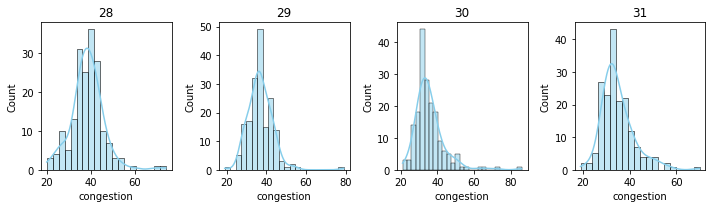

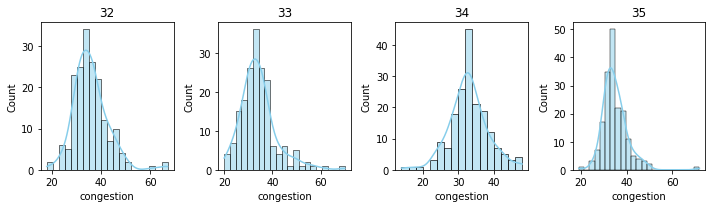

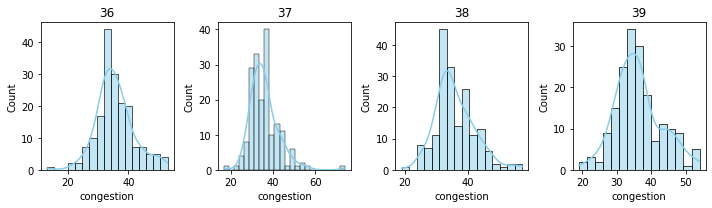

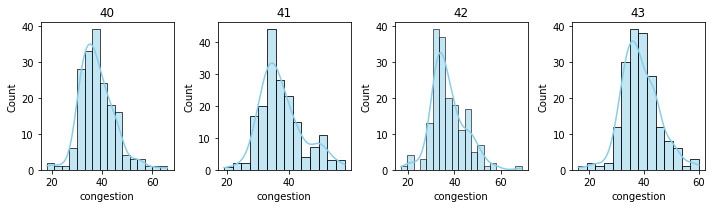

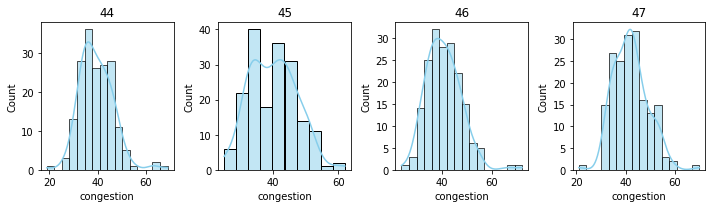

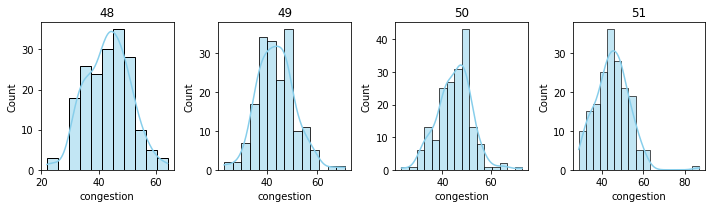

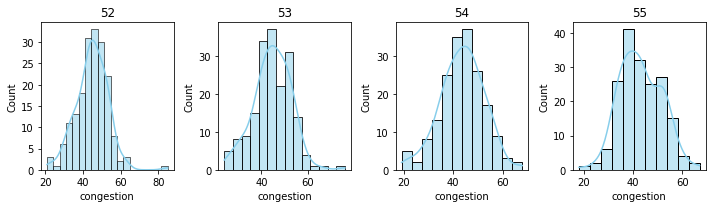

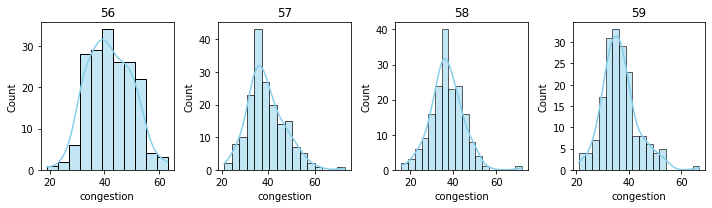

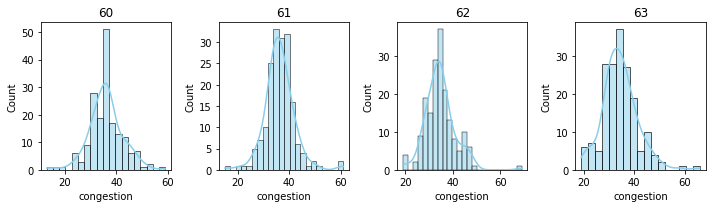

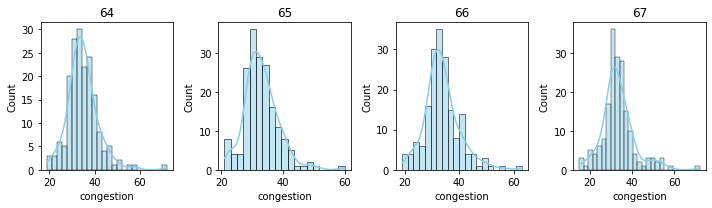

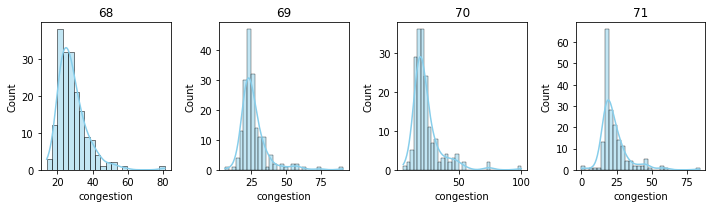

In [22]:
dt = _22ne.daytime_id.unique()

i=0
while i < len(dt):
    fig, axs = plt.subplots(1,4,figsize=(10, 3))
    sns.histplot(data=train,x=_22ne.congestion[_22ne.daytime_id==dt[i]], kde=True, color="skyblue",ax=axs[0])
    axs[0].set_title(f'{dt[i]}')
    sns.histplot(data=train,x=_22ne.congestion[_22ne.daytime_id==dt[i+1]], kde=True, color="skyblue",ax=axs[1])
    axs[1].set_title(f'{dt[i+1]}')
    sns.histplot(data=train,x=_22ne.congestion[_22ne.daytime_id==dt[i+2]], kde=True, color="skyblue",ax=axs[2])
    axs[2].set_title(f'{dt[i+2]}')
    sns.histplot(data=train,x=_22ne.congestion[_22ne.daytime_id==dt[i+3]], kde=True, color="skyblue",ax=axs[3])
    axs[3].set_title(f'{dt[i+3]}')
   
    i+=4
    plt.tight_layout()
    plt.show()

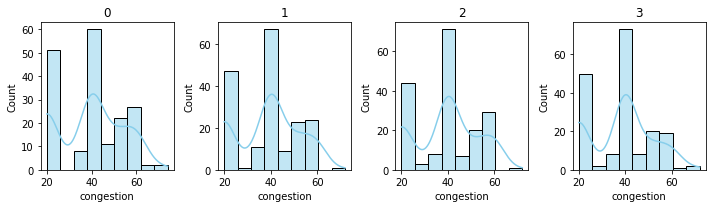

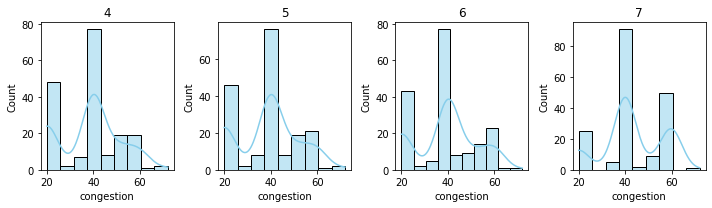

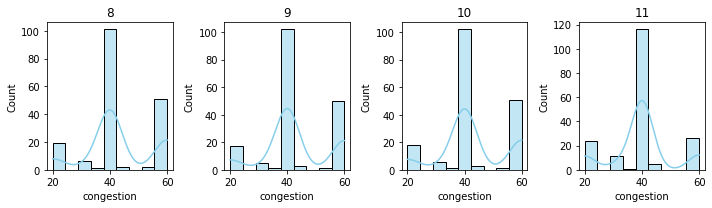

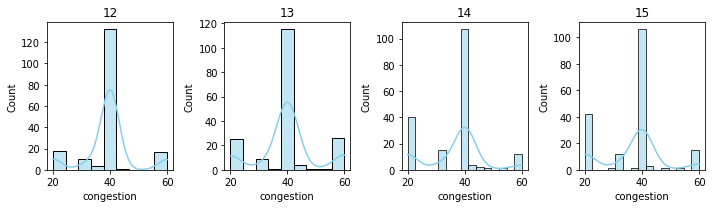

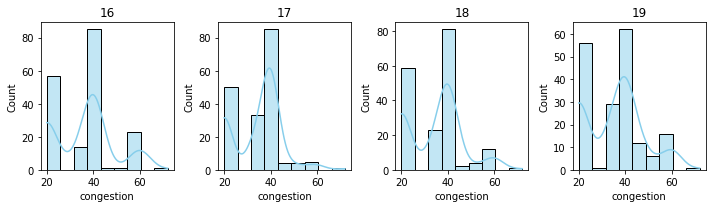

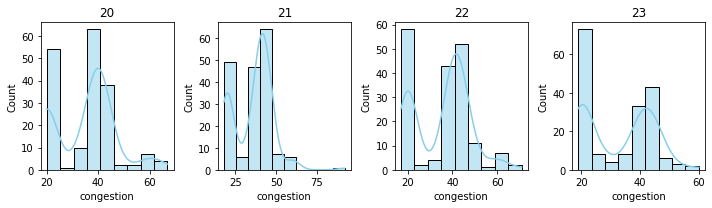

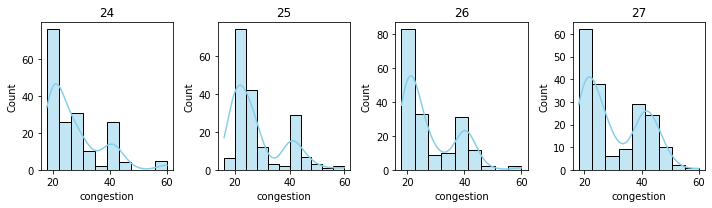

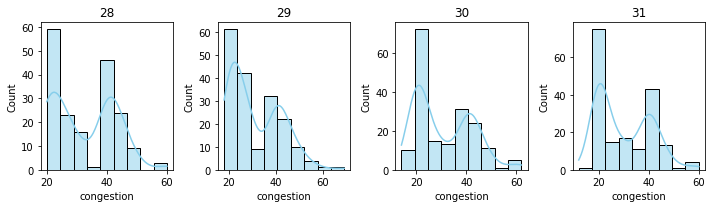

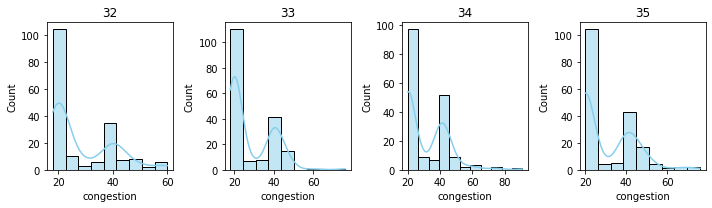

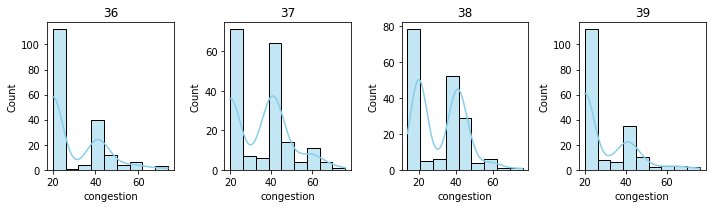

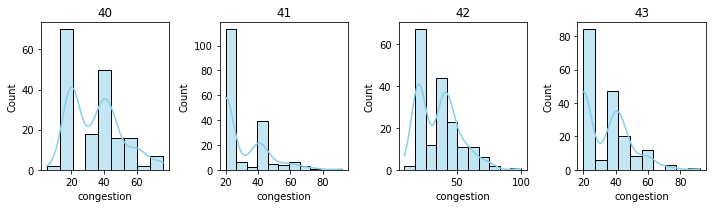

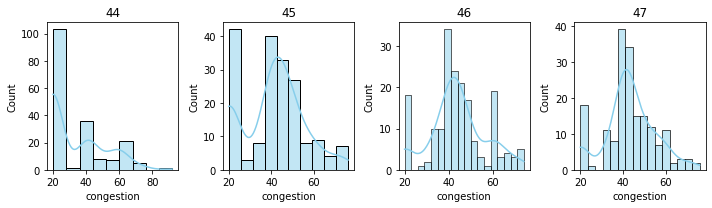

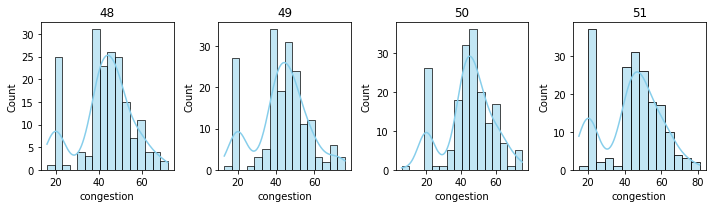

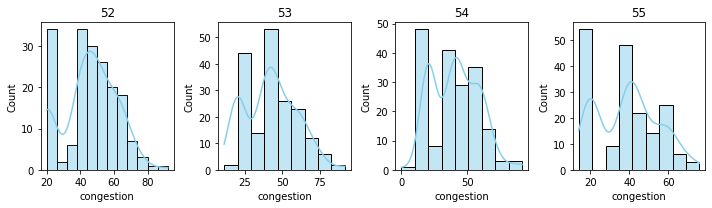

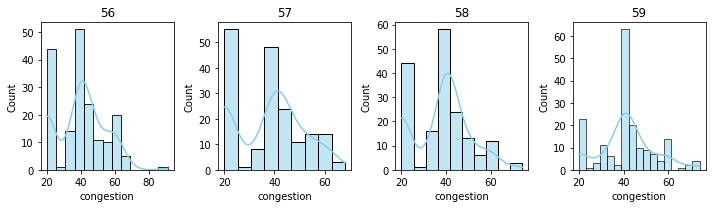

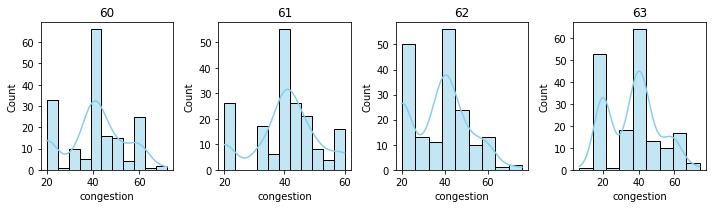

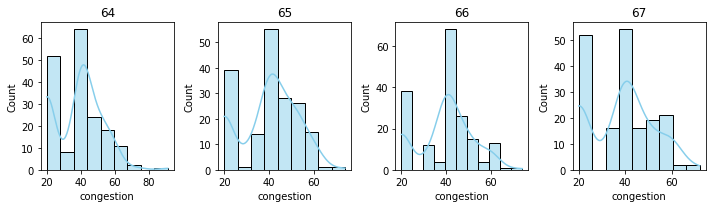

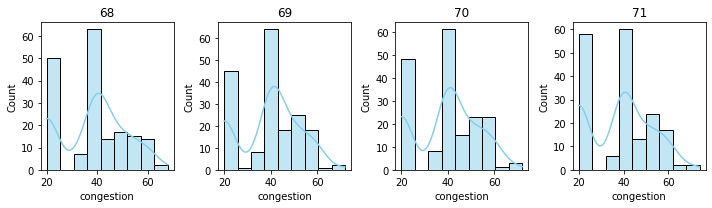

In [23]:
dt = _22se.daytime_id.unique()

i=0
while i < len(dt):
    fig, axs = plt.subplots(1,4,figsize=(10, 3))
    sns.histplot(data=train,x=_22se.congestion[_22se.daytime_id==dt[i]], kde=True, color="skyblue",ax=axs[0])
    axs[0].set_title(f'{dt[i]}')
    sns.histplot(data=train,x=_22se.congestion[_22se.daytime_id==dt[i+1]], kde=True, color="skyblue",ax=axs[1])
    axs[1].set_title(f'{dt[i+1]}')
    sns.histplot(data=train,x=_22se.congestion[_22se.daytime_id==dt[i+2]], kde=True, color="skyblue",ax=axs[2])
    axs[2].set_title(f'{dt[i+2]}')
    sns.histplot(data=train,x=_22se.congestion[_22se.daytime_id==dt[i+3]], kde=True, color="skyblue",ax=axs[3])
    axs[3].set_title(f'{dt[i+3]}')
   
    i+=4
    plt.tight_layout()
    plt.show()

Each congestion for each daytime id looks similiar to the distribution of the previous day time id. 

# Average Congestion Per Direction

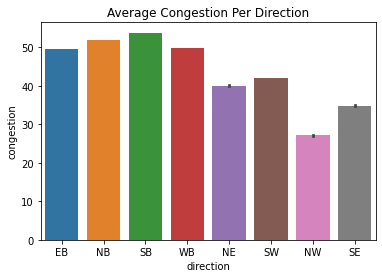

In [24]:
sns.barplot(x='direction',y='congestion',data=train).set(title='Average Congestion Per Direction')
sns.set(style='white')
plt.show()

# Average Congestion Per Hour

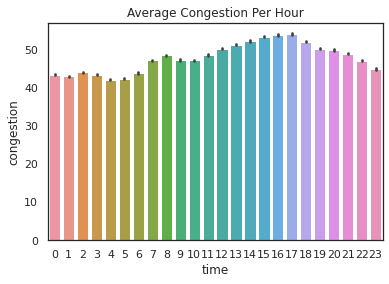

In [25]:
sns.barplot(x=train.time.dt.hour,y='congestion',data=train).set(title='Average Congestion Per Hour')
sns.set(style='white')
plt.show()